# MDC 018 - Projeto Final

In [21]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_critic = pd.read_csv("train_critic.csv")

test_critic = pd.read_csv("test_critic.csv")

Verificação de balanceamento:

In [22]:
dataset_sentiment_0 = train_critic.loc[train_critic['Sentiment'] == 0]
dataset_sentiment_1 = train_critic.loc[train_critic['Sentiment'] == 1]

In [23]:
dataset_sentiment_1 = dataset_sentiment_1.sample(n=5000, random_state=42)
dataset_sentiment_1

,Show,Sentiment,Review
3712,The White Lotus,1,"Go in expecting a pleasing, intelligent, and well-paced romp, one that definitely won't make you miss overseas travel."
1683,Twin Peaks,1,"Twin Peaks: The Return was ghastly, comic, romantic, mysterious, and unlike anything ever to come before it. It was some damn fine coffee."
5335,The Essex Serpent,1,"If Perry's book is a novel of sensation posing as a novel of ideas, then Anna Symon's screenplay is more of the same; if you're after melodrama, you're in the right place."
44,My Brilliant Friend,1,"For those who luxuriated in its first two seasons, it remains as gorgeous and seductive as ever."
5334,Shining Girls,1,"It’s an intriguing watch, and Moss’ patented, unglamorous intensity is rewarding."
...,...,...,...
6902,Lost,1,"Some of those actors are giving superlative, career-high performances - no one on TV today is showing greater range and emotion than O'Quinn, for example."
4131,Alias Grace,1,The performances are uniformly first-rate...
6193,You,1,"Despite a few dull moments, the show remains pretty sharp."
4226,The Act,1,"All the writing was so well done, and each of the directors who came on-board kept things visually interesting, offering compelling imagery and juxtaposition of scenes that really helped the whole story, and its important themes, shine bright."


In [24]:
dataset_sentiment_0.to_csv("dataset_sentiment_0.csv", index=False)

In [25]:
dataset_sentiment_0_oversampled = pd.read_csv("dataset_sentiment_oversampled.csv")


In [26]:
train_critic = pd.concat([dataset_sentiment_1, dataset_sentiment_0_oversampled], ignore_index=True)

# Embaralhar as amostras
train_critic = train_critic.sample(frac=1, random_state=42).reset_index(drop=True)
train_critic

,Show,Sentiment,Review
0,Mad Men,0,"With each new season, I try to remind myself that the show is a slow burn. The first episode wasn't as glacial as the first episode of last season, but it still dragged a bit."
1,Black Mirror,1,"The concepts are simple, and yet showrunners Charlie Brooker and Annabel Jones find evermore potent ways to drive down into humanity's darker instincts."
2,Rick and Morty,1,"The Season 5 premiere doesn't necessarily feel like a return to ""classic"" Rick and Morty, and nor does it feel like a dramatic departure. But the episode's straightforwardness... is a welcome shift."
3,Band of Brothers,1,What is perhaps most striking about the project is its revelation of the ordinariness of heroism.
4,The Me You Can't See,1,A revealing look at mental illness and how our awareness of how pervasive it is in its many forms is just starting to develop.
...,...,...,...
9995,Night Sky,0,"Despite strong performances by Simmons and Spacek, this series just plods along with only mildly entertaining bits of story."
9996,Halo,0,"Schreiber is, indeed, the most interesting thing about Halo -- which isn’t necessarily saying all that much."
9997,WeCrashed,0,NaN
9998,Central Park,1,"Season two explores these notions with emotional depth and backstory, which anchors its many moving parts."


Ambos conjuntos estão fortemente desbalanceados.

# Predição de sentimento

Conjunto train_critic

In [27]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_critic.dropna(subset=['Review'], inplace=True)

(train_critic_df, val_critic_df) = train_test_split(train_critic, test_size=0.2)
train_critic_df['Sentiment'].value_counts()

Sentiment
1    4016
0    3977
Name: count, dtype: int64

In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_critic['Sentiment'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_critic['Sentiment']
)

class_weights = dict(zip(classes, weights))
class_weights

{np.int64(0): np.float64(1.0008012820512822), np.int64(1): np.float64(0.9992)}

In [29]:
val_critic_texts = val_critic_df["Review"].tolist()
val_critic_labels = val_critic_df["Sentiment"].tolist()

In [30]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = []

    for text in texts:
        result = classifier(text)
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)
    return round(float(balanced_accuracy_score(labels, predictions)),2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

In [31]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score


model_name = "prajjwal1/bert-small"  # Ou outro checkpoint pré-treinado
num_labels = 2  # Número de classes no seu problema

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_critic['Sentiment']  # Altere para acessar os rótulos no seu dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_critic_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_critic_df['Review']), truncation=True, padding=True, max_length=128)

In [33]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [34]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [35]:
training_args = TrainingArguments(
    output_dir="./results_critic_llm_oversample_tuned_electra",
    learning_rate=5e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)
train_critic_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_critic_df['Sentiment'])
})

val_critic_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_critic_df['Sentiment'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_critic_dataset,
    eval_dataset=val_critic_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.392500,0.362539,0.874772
2,0.258400,0.351481,0.909576
3,0.134700,0.465045,0.913777
4,0.060300,0.477774,0.915270
5,0.027200,0.439654,0.925972


TrainOutput(global_step=5000, training_loss=0.18983164024353028, metrics={'train_runtime': 2252.1629, 'train_samples_per_second': 17.745, 'train_steps_per_second': 2.22, 'total_flos': 234620701177680.0, 'train_loss': 0.18983164024353028, 'epoch': 5.0})

In [36]:
get_balanced_accuracy(model, tokenizer, val_critic_texts, val_critic_labels)

0.93

In [37]:
trainer.evaluate()

{'eval_loss': 0.43965426087379456,
 'eval_balanced_accuracy': 0.9259722055348631,
 'eval_runtime': 15.987,
 'eval_samples_per_second': 125.039,
 'eval_steps_per_second': 15.638,
 'epoch': 5.0}

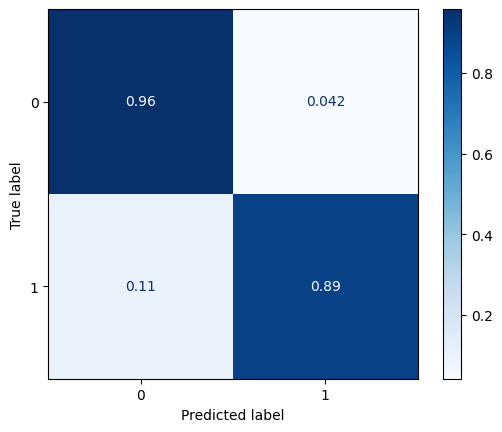

array([[0.95763547, 0.04236453],
       [0.10569106, 0.89430894]])

In [38]:
plot_confusion_matrix(trainer,val_critic_dataset)

# Teste

In [39]:
test_critic_texts = test_critic["Review"].tolist()
test_critic_labels = test_critic["Sentiment"].tolist()
get_balanced_accuracy(model, tokenizer, test_critic_texts, test_critic_labels)

0.76

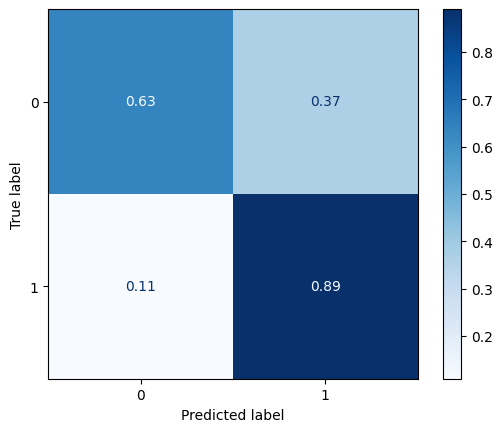

array([[0.63474388, 0.36525612],
       [0.10996016, 0.89003984]])

In [40]:
test_encodings = tokenizer(list(test_critic['Review']), truncation=True, padding=True, max_length=128)
test_critic_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_critic['Sentiment'])
})
plot_confusion_matrix(trainer,test_critic_dataset)